In [1]:
!nvidia-smi

Wed Apr 26 15:50:30 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A4000                On | 00000000:01:00.0 Off |                  Off |
| 41%   41C    P8               16W / 140W|   1487MiB / 16376MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/home/ee19b004/Desktop/Training


In [3]:
SOURCE_VIDEO_PATH = f"/home/ee19b004/Desktop/Training/videos/heavy-vehicle-detection.mp4"
# SOURCE_VIDEO_PATH = 0

In [4]:
# Pip install method (recommended)

%pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.73 🚀 Python-3.8.10 torch-2.0.0+cu117 CUDA:0 (NVIDIA RTX A4000, 16109MiB)
Setup complete ✅ (16 CPUs, 62.6 GB RAM, 76.3/226.3 GB disk)


In [5]:
%cd {HOME}/ByteTrack

/home/ee19b004/Desktop/Training/ByteTrack


In [6]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [7]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [8]:
%pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [9]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

In [10]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections, 
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)
    
    tracker_ids = [None] * len(detections)
    
    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

In [11]:
# settings
MODEL = "/home/ee19b004/Desktop/Training/Trainings/runs/segment/train/weights/best.pt"

In [12]:
from ultralytics import YOLO

model = YOLO(MODEL) 

In [13]:
CLASS_NAMES_DICT = model.model.names

CLASS_ID = [0,1,2,3,4,5,6]
# CLASS_ID = [0,1]

print(model.model.names)

{0: 'A-10-Tridem', 1: 'A-13', 2: 'Axle', 3: 'Type-2', 4: 'Type-2-S2', 5: 'Type-3', 6: 'Unclassified'}



0: 384x640 (no detections), 59.2ms
Speed: 0.8ms preprocess, 59.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


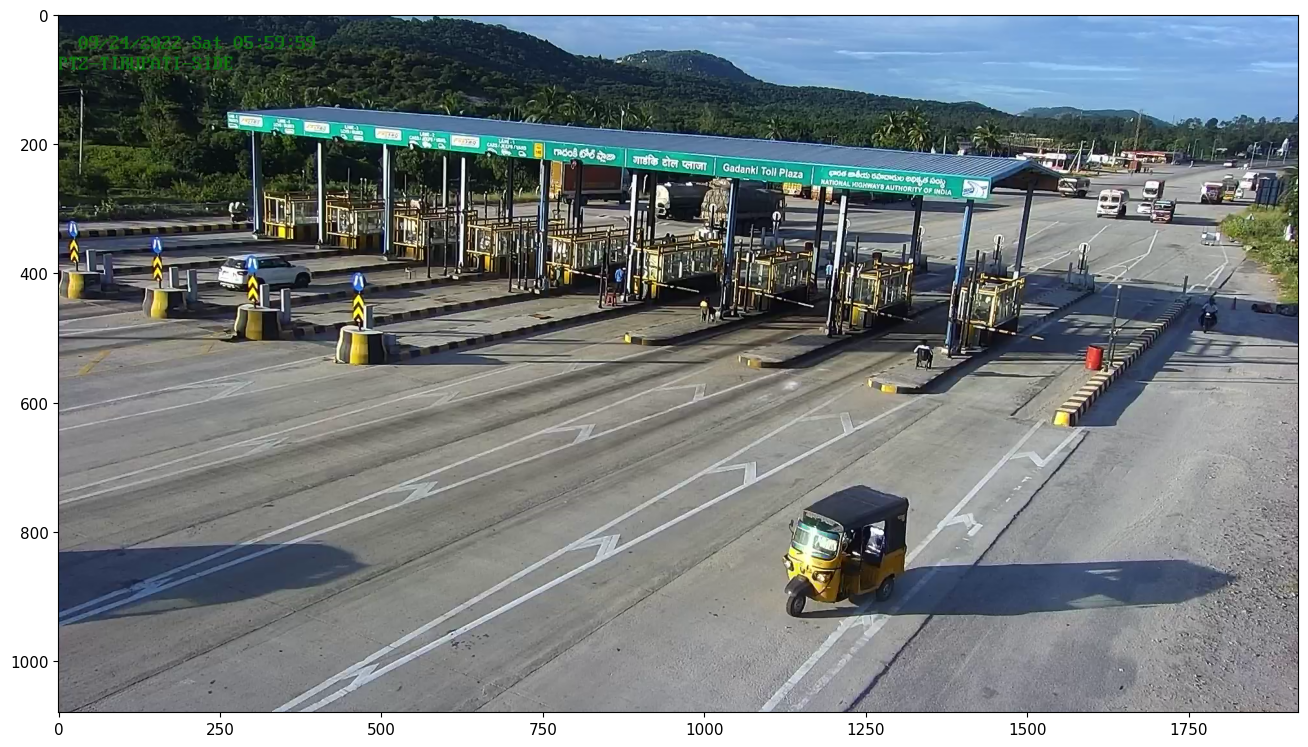

In [14]:
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.8f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

In [15]:
# settings
LINE_START = Point(50, 1500)
LINE_END = Point(3840-50, 1500)

TARGET_VIDEO_PATH = f"{HOME}/videos/vehicle-counting-result.mp4"

In [16]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1920, height=1080, fps=25, total_frames=9500)

In [17]:
# from tqdm.notebook import tqdm


# # create BYTETracker instance
# byte_tracker = BYTETracker(BYTETrackerArgs())
# # create VideoInfo instance
# video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# # create frame generator
# generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# # create LineCounter instance
# line_counter = LineCounter(start=LINE_START, end=LINE_END)
# # create instance of BoxAnnotator and LineCounterAnnotator
# box_annotator = BoxAnnotator(color=ColorPalette(), thickness=2, text_thickness=1, text_scale=1)
# line_annotator = LineCounterAnnotator(thickness=1, text_thickness=1, text_scale=1)

# # open target video file
# with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
#     # loop over video frames
#     for frame in tqdm(generator, total=video_info.total_frames):
#         # model prediction on single frame and conversion to supervision Detections
#         results = model(frame)
#         detections = Detections(
#             xyxy=results[0].boxes.xyxy.cpu().numpy(),
#             confidence=results[0].boxes.conf.cpu().numpy(),
#             class_id=results[0].boxes.cls.cpu().numpy().astype(int)
#         )
#         # filtering out detections with unwanted classes
#         mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
#         detections.filter(mask=mask, inplace=True)
#         # tracking detections
#         tracks = byte_tracker.update(
#             output_results=detections2boxes(detections=detections),
#             img_info=frame.shape,
#             img_size=frame.shape
#         )
#         tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
#         detections.tracker_id = np.array(tracker_id)
#         # filtering out detections without trackers
#         mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
#         detections.filter(mask=mask, inplace=True)
#         # format custom labels
#         labels = [
#             f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
#             for _, confidence, class_id, tracker_id
#             in detections
#         ]
#         # updating line counter
#         line_counter.update(detections=detections)
#         # annotate and display frame
#         frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)



        
#         line_annotator.annotate(frame=frame, line_counter=line_counter)
#         sink.write_frame(frame)

In [18]:
from tqdm.notebook import tqdm


# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create LineCounter instance
line_counter = LineCounter(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=2, text_thickness=1, text_scale=1)
line_annotator = LineCounterAnnotator(thickness=1, text_thickness=1, text_scale=1)

vehicle_count = 0
data = {}
temp = []

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # format custom labels

        
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        # updating line counter
        line_counter.update(detections=detections)
        # annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

        line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)


        # val -> [[xyxy], confidence, class_id, track_id]
        for val in detections:
            if(data.__contains__(val[3])):
                if(data[val[3]]['confidence']< val[1]):
                    data[val[3]]['confidence'] = val[1]
                    data[val[3]]['class_type'] = CLASS_NAMES_DICT[val[2]]
            else:
                data.__setitem__(val[3] , {'confidence' : val[1], 'class_type' : CLASS_NAMES_DICT[int(val[2])]})
            temp.append(val)
            

  0%|          | 0/9500 [00:00<?, ?it/s]


0: 384x640 (no detections), 5.6ms
Speed: 0.3ms preprocess, 5.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.7ms
Speed: 0.2ms preprocess, 5.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.8ms
Speed: 0.4ms preprocess, 5.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.7ms
Speed: 0.2ms preprocess, 5.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.3ms
Speed: 0.2ms preprocess, 4.3ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 0.2ms preprocess, 4.0ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.1ms
Speed: 0.2ms preprocess, 4.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.5ms
Speed: 0.5ms preprocess, 4.5ms inference, 0.2ms 

In [19]:
for entry in data.values():
    if(entry['class_type']!="Axle" and entry['confidence']>=0.8):
        print(entry['class_type'], entry['confidence'])
            
 

Type-2 0.9490174
Type-2 0.9296706
Type-2 0.8313181
Type-3 0.9392458
Type-2 0.930787
A-10-Tridem 0.92759776
Type-2-S2 0.8206871
Type-2-S2 0.803801
Type-2 0.8345589


In [20]:
min_confidence = 0.8
vehicle_count = 0

vehicle = {}

for entry in data.values():
    if(entry['confidence']>=min_confidence):
        if(entry['class_type']!="Axle"):
            vehicle_count+=1
            if(vehicle.__contains__(entry['class_type'])):
                vehicle[entry['class_type']]+=1
            else:
                vehicle[entry['class_type']]=1
            
    


In [21]:
print(data)

{1: {'confidence': 0.7988058, 'class_type': 'Type-2-S2'}, 7: {'confidence': 0.5120048, 'class_type': 'Axle'}, 8: {'confidence': 0.43622294, 'class_type': 'Axle'}, 9: {'confidence': 0.9490174, 'class_type': 'Type-2'}, 10: {'confidence': 0.50749916, 'class_type': 'Axle'}, 20: {'confidence': 0.73294586, 'class_type': 'Axle'}, 21: {'confidence': 0.43548086, 'class_type': 'Axle'}, 22: {'confidence': 0.5643027, 'class_type': 'Axle'}, 28: {'confidence': 0.9296706, 'class_type': 'Type-2'}, 29: {'confidence': 0.56099826, 'class_type': 'Axle'}, 31: {'confidence': 0.5220318, 'class_type': 'Axle'}, 32: {'confidence': 0.5195578, 'class_type': 'Axle'}, 35: {'confidence': 0.7650238, 'class_type': 'Axle'}, 34: {'confidence': 0.66227365, 'class_type': 'Axle'}, 37: {'confidence': 0.344961, 'class_type': 'Type-3'}, 40: {'confidence': 0.72429967, 'class_type': 'Axle'}, 44: {'confidence': 0.5153092, 'class_type': 'Type-2'}, 45: {'confidence': 0.7321778, 'class_type': 'Axle'}, 46: {'confidence': 0.4273694, 

In [22]:
print("Vehicle count in the video is: " + str(vehicle_count))
print()

import json
json_object = json.dumps(vehicle, indent = 4) 
print(json_object)


# 3 1
# 4 2
# 


Vehicle count in the video is: 9

{
    "Type-2": 5,
    "Type-3": 1,
    "A-10-Tridem": 1,
    "Type-2-S2": 2
}
